## Fourier transform

Numpy documentation at https://numpy.org/doc/stable/reference/routines.fft.html . Scipy documentation and examples at https://docs.scipy.org/doc/scipy/tutorial/fft.html

The data files used in this notebook can be downlodaded from the "Classrom exercises" section on moodle

### Example: signal + noise

In this example we download from the file pitch.txt a signal made of a basic wave, in which we recognize sone high freqency noise component and we perform basic denoising by Fourier transforming, removing the high-k coefficients and transforming back.

In [2]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt

##### 1) Downloading and plotting signal

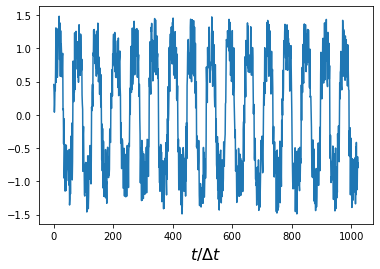

In [3]:
pitch = np.genfromtxt('pitch.txt')

plt.plot(pitch)
plt.xlabel('$t/\Delta t$', size = 16)
plt.show()

##### 2) FT and power spectrum

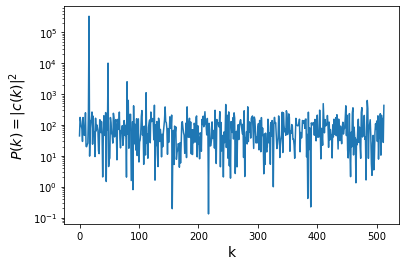

In [4]:
ck = np.fft.rfft(pitch)
power = (abs(ck))**2

plt.plot(power)
plt.xlabel('k', size = 14)
plt.ylabel('$P(k) = |c(k)|^2$', size = 14)
plt.yscale('log')
plt.show()

##### 3) Denoising

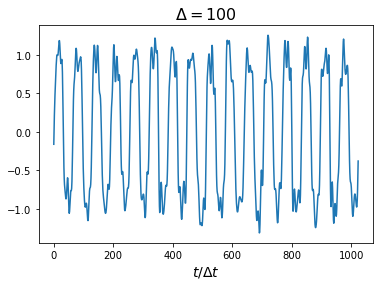

In [11]:
kmax = np.argmax(power)

# Removing high frequency coefficients
Delta = 100
dck = ck.copy()
dck[kmax + Delta:] = 0.0
denoised_pitch = np.fft.irfft(dck)
plt.xlabel('$t/ \Delta t$', size = 14)
plt.title('$\Delta = $' + str(Delta), size = 16)
plt.plot(denoised_pitch)
plt.show()

### Example: unblurring

In this example we download a blurred image from the file blur.txt. Knowing that the point spread function is a Gaussian with $\sigma$ = 25, we unblur it via PSF deconvolution, which is just a division by the PSF in Fourier space.

In [9]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

#### Reading file and displaying image

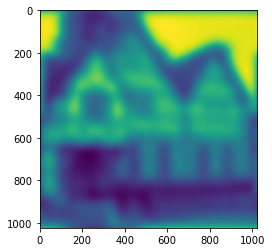

In [10]:
image = np.genfromtxt('blur.txt')
plt.imshow(image)
plt.show()
K, L = image.shape

#### Generating and plotting the PSF

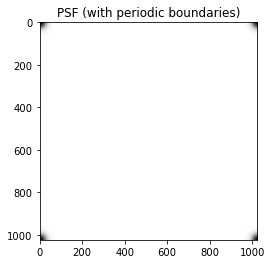

In [11]:
size = len(image)
sigma = 23

def PSF(sigma,size):
    # Point spread function sampled in image grid
    def gauss(x,y,sigma):
        norm = 1./(2.*sigma**2)
        f = norm*np.exp(-(x**2 + y**2)/(2.*sigma**2))
        return f
    gauss = np.vectorize(gauss)
    x = np.linspace(0,size,size)
    y = np.linspace(0,size,size)
    X,Y = np.meshgrid(x,y)
    W = gauss(X,Y,sigma) + gauss(X-size,Y,sigma) + gauss(X,Y-size,sigma) + gauss(X-size,Y-size,sigma)
    return W

W = PSF(sigma,size)

plt.imshow(W,cmap='Greys')
plt.title('PSF (with periodic boundaries)')
plt.show()


#######################################################
# Calculating PSF with loops, instead of vectorizing

#def PSF(x,y,sigma):
#    norm = 1./(2.*sigma**2)
#    f = norm*np.exp(-(x**2 + y**2)/(2.*sigma**2))
#    return f

#W = np.empty_like(image)
#size = len(W)
#sigma = 23

# Calculating PSF with loops
#for x in range (len(W)):
#    for y in range(len(W)):
#        W[x,y] = PSF(x,y,sigma) + PSF(x-size,y,sigma) + PSF(x,y-size,sigma) + PSF(x-size,y-size,sigma)

#plt.imshow(W,cmap='Greys')
#plt.title('PSF (with periodic boundaries)')
#plt.show()

#### Deconvolving the PSF and comparing images before and after unblurring

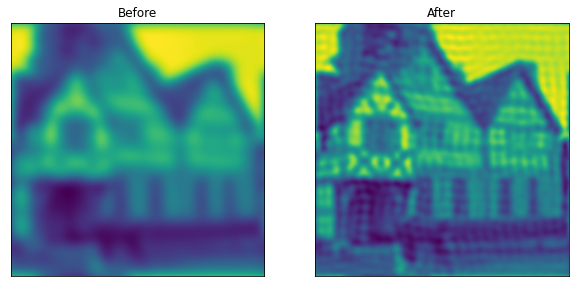

In [13]:
ck_img = np.fft.rfft2(image)
ck_W = np.fft.rfft2(W)

K, L = ck_W.shape

# Deconvolving PSF by division in Fourier space 
ck_unblur = np.copy(ck_img)
for i in range(K):
    for j in range(L):        
        if(abs(ck_W[i,j])>1e-3):
            ck_unblur[i,j] = ck_img[i,j]/(ck_W[i,j])

# Fourier transforming back to get the unblurred image
img_unblur = np.fft.irfft2(ck_unblur)          
            
# Plotting    
compare = display(image,img_unblur)

def display(original,filtered):
    fig, axs = plt.subplots(1,2,figsize=(10,6))
    axs[0].set_title('Before')
    axs[0].imshow(original)
    axs[1].imshow(filtered)
    axs[1].set_title('After')
    # remove the x and y ticks
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

### Example. Adding noise

We now add noise to the image, besides the blurring. If we deconvolve the PSF, in this case we incorretly deconvolve also the noise. This can lead to catastrophic effects.

In [14]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

1024 1024


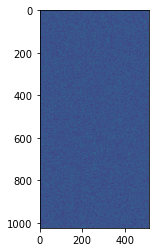

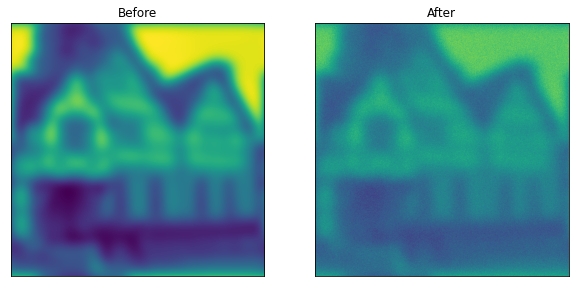

In [15]:
def display(original,filtered):
    fig, axs = plt.subplots(1,2,figsize=(10,6))
    axs[0].set_title('Before')
    axs[0].imshow(original)
    axs[1].imshow(filtered)
    axs[1].set_title('After')
    # remove the x and y ticks
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

image = np.genfromtxt('blur.txt')
K, L = image.shape

print(K,L)

# Adding noise
sigma = 100
frac = 0.
def add_noise(image,std,highpass):
    # Adding noise to the image
    # Generating Gaussian noise in pixel space
    K, L = image.shape
    mean = 0
    seed = 2938645
    np.random.seed(seed)
    noise = np.random.normal(mean,std,size=(K,L))
    # Removing low frequency noise components in Fourier space
    nk = np.fft.rfft2(noise)
    keep_fraction = highpass
    nk[0:int(K*highpass)] = 0
    nk[int(K*(1-highpass)):] = 0
    nk[:,0:int(K*highpass)] = 0
    # Fourier transforming back to get filtered noise field
    # in pixel space
    noise = np.fft.irfft2(nk)
    plt.imshow(abs(nk))
    return image + noise
    
image2 = add_noise(image,sigma,frac)

compare = display(image,image2)

##### Point spread function

In [16]:
sigma = 23
size=1024

def PSF(sigma,size):
    # Point spread function sampled in image grid
    def gauss(x,y,sigma):
        norm = 1./(2.*sigma**2)
        f = norm*np.exp(-(x**2 + y**2)/(2.*sigma**2))
        return f
    gauss = np.vectorize(gauss)
    x = np.linspace(0,size,size)
    y = np.linspace(0,size,size)
    X,Y = np.meshgrid(x,y)
    W = gauss(X,Y,sigma) + gauss(X-size,Y,sigma) + gauss(X,Y-size,sigma) + gauss(X-size,Y-size,sigma)
    return W

W = PSF(sigma,size)

#plt.imshow(W,cmap='Greys')
#plt.title('PSF (with periodic boundaries)')
#plt.show()

#### Deconvolution

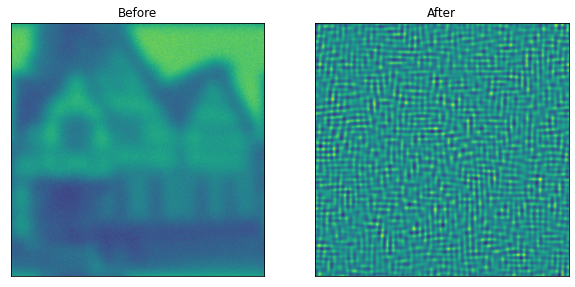

In [17]:
ck_W = np.fft.rfft2(W)
ck_img = np.fft.rfft2(image2)

K, L = ck_W.shape
# Deconvolving PSF by division in Fourier space 
ck_unblur = np.copy(ck_img)
for i in range(K):
    for j in range(L):        
        if(abs(ck_W[i,j])>1e-3):
            ck_unblur[i,j] = ck_img[i,j]/(ck_W[i,j])

# Fourier transforming back to get the unblurred image
img_unblur = np.fft.irfft2(ck_unblur).real          
            
# Plotting    
compare = display(image2,img_unblur) 

### Exercise: musical instruments 

Files piano.txt and trumpet.txt contain a sampling at 44100 Hz of a single note, played by a piano and a trumpet.

1) Load the waveforms and plot them

2) Apply fft and plot the first 10000 coefficients of the power spectrum, for both instruments

3) Which note where the two instruments playing? [hint: the note middle C ('do') has a frequency of 216 Hz]

###### 1) Loading and plotting waveforms

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

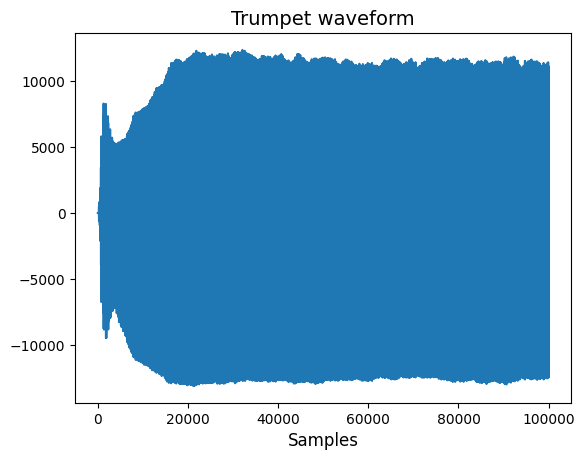

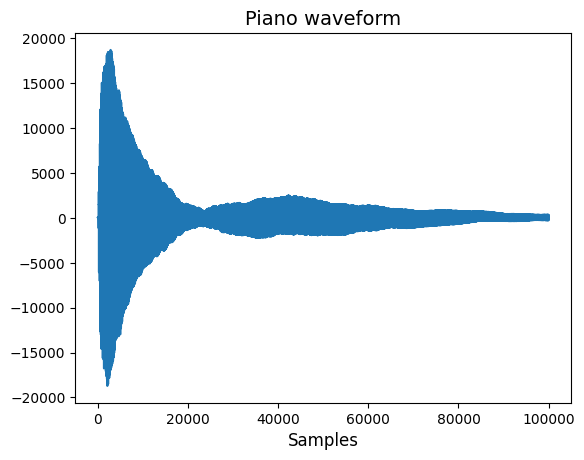

In [3]:
trumpet = np.genfromtxt('trumpet.txt')
plt.plot(trumpet)
plt.title('Trumpet waveform', size = 14)
plt.xlabel('Samples', size = 12)
plt.show()

piano = np.genfromtxt('piano.txt')
plt.plot(piano)
plt.title('Piano waveform', size = 14)
plt.xlabel('Samples', size = 12)
plt.show()

##### 2) Doing FFT and plotting spectra

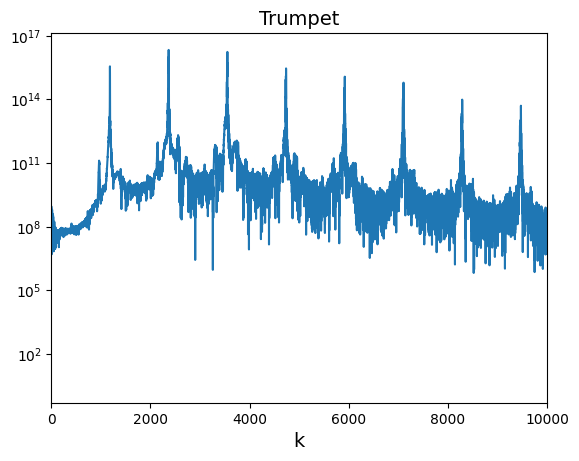

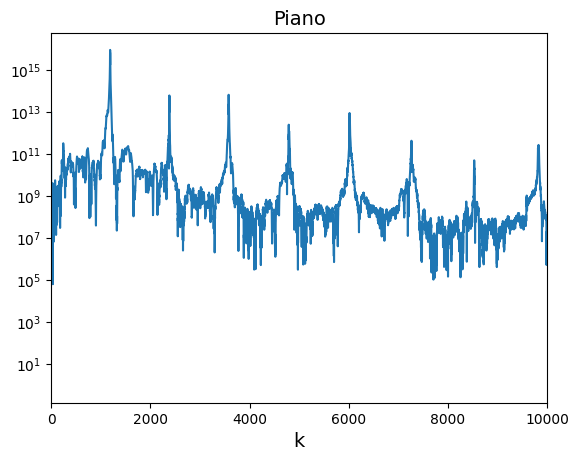

In [4]:
# Trumpet
trumpetk = np.fft.rfft(trumpet)
plt.xlim(0,10000)
plt.plot(abs(trumpetk)**2)
plt.yscale('log')
plt.title('Trumpet', size = 14)
plt.xlabel('k', size = 14)
plt.show()

# Piano
pianok = np.fft.rfft(piano)
plt.xlim(0,10000)
plt.yscale('log')
plt.title('Piano', size = 14)
plt.xlabel('k', size = 14)
plt.plot(abs(pianok)**2)
plt.show()

##### 3) Finding which note the instruments where playing

To do that: find the maximum of the power spectrum and convert to frequency, knowing that the sampling frequency was 44100 Hz. 

Note: remember that when you use rfft, for real signals, the length of the Fourier coefficient array is N//2 + 1, since negative frequencies are not computed by rfft (the coeeficients are in this case complex conjugates of the positive frequencies)

In [30]:
# Trumpet
sampling_freq = 44100
kmax = np.argmax(abs(trumpetk)**2)
f = (kmax/(len(trumpet)))*44100
print('Trumpet largest frequency component (in units of 261 Hz), f = ', f/261)

# Piano
kmax = np.argmax(abs(pianok)**2)
f = (kmax/(len(piano)))*44100
print('Piano largest frequency component (in units of 261 Hz), f = ', f/261)

Trumpet largest frequency component (in units of 261 Hz), f =  3.9994137931034484
Piano largest frequency component (in units of 261 Hz), f =  2.0106896551724143


#### Same as above, but now using python built-in np.fft.rfftfreq to find frequencies.

Piano largest frequency component (in units of 261 Hz), f =  2.010689655172414
 


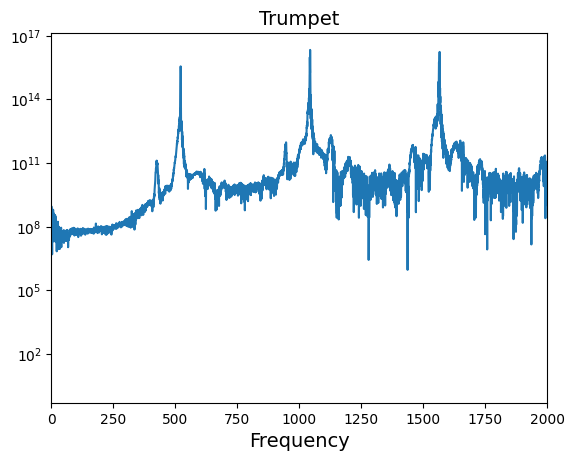

Trumpet largest frequency component (in units of 261 Hz), f =  3.9994137931034484
 


In [36]:
# Frequencies using python built-in functions
sample_rate = 44100.  #Hz
middleC = 261 # Hz

# Piano
pianok = np.fft.rfft(piano)
freq = np.fft.rfftfreq(len(piano),d=1./sample_rate)
kmax = np.argmax(abs(pianok)**2)

plt.xlim(0,2000)
plt.yscale('log')
plt.title('Piano', size = 14)
plt.xlabel('Frequency', size = 14)
plt.plot(freq,abs(pianok)**2)
plt.show()

print('Piano largest frequency component (in units of 261 Hz), f = ', freq[kmax]/middleC)
print(' ')

# Trumpet
trumpetk = np.fft.rfft(trumpet)
freq = np.fft.rfftfreq(len(trumpet),d=1./sample_rate)
kmax = np.argmax(abs(trumpetk)**2)

plt.xlim(0,2000)
plt.yscale('log')
plt.title('Trumpet', size = 14)
plt.xlabel('Frequency', size = 14)
plt.plot(freq,abs(trumpetk)**2)
plt.show()

print('Trumpet largest frequency component (in units of 261 Hz), f = ', freq[kmax]/middleC)
print(' ')

### Exercise: sunsposts

Download the sunspot data from the file sunspots.txt. The file contains two columns. The first column shows time, measured in months, starting from January 1749; the second column contains the observed number of sunspots in each month.

1) Plot the number of sunspots as a function of time. Get a by eye estimate of the length of the cycle.

2) Fourier transform the data and plot the power spectrum ($|c_k|^2$ as a function of k)

3) Find the power spectrum peak for k>0. What does the $|c(0)|^2$ value represent?

4) Find the period of the wave-term corresponding to the peak measured in 3) and compare to your estimate in 1)

(if you want, you can solve it using your own DFT script, and compare with FFT numpy results, verifying also the difference in performance betwen the two algorithms)

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

#### 1) Plotting data

3143


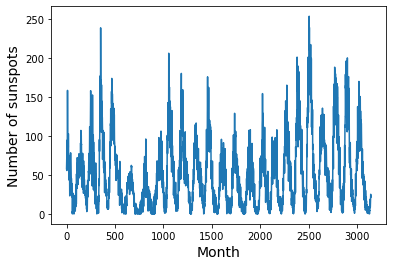

In [13]:
spots = np.genfromtxt('sunspots.txt')

# Numbe of data
N = len(spots[:,0])
print(N)

plt.xlabel('Month', size = 14)
plt.ylabel('Number of sunspots',size = 14)
#plt.xlim(2000,2500)
plt.plot(spots[:,0],spots[:,1])
plt.show()

#### Zooming to get an estimate of the period

We get an estimate of about 100-140 months 

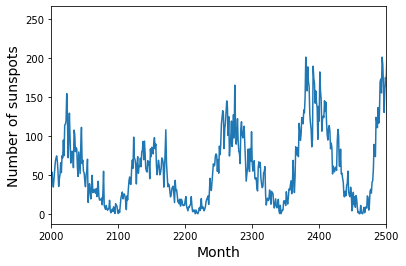

In [14]:
plt.xlabel('Month', size = 14)
plt.ylabel('Number of sunspots',size = 14)
plt.xlim(2000,2500)
plt.plot(spots[:,0],spots[:,1])
plt.show()

#### 2) Fourier transform and power spectrum

By plotting |c(k)|^2 we would see a large peak for k=0. This is just a constant offset (monopole), giving the average value 
of sunspots over the entire period of observation. Since we are interested in cycles, we remove it

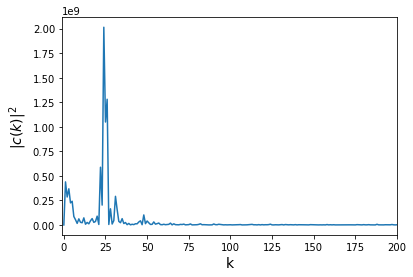

In [16]:
# Fourier transform
ck = np.fft.rfft(spots[:,1])
# Removing monopole
ck[0] = 0

plt.plot(abs(ck)**2)
#plt.yscale('log')
plt.xlim(-1,200)
plt.xlabel('k',size = 14)
plt.ylabel('$|c(k)|^2$',size=14)
plt.show()

#### 3) Finding maximum of power spectrum and plotting corresponding mode, in comparison with the observed data

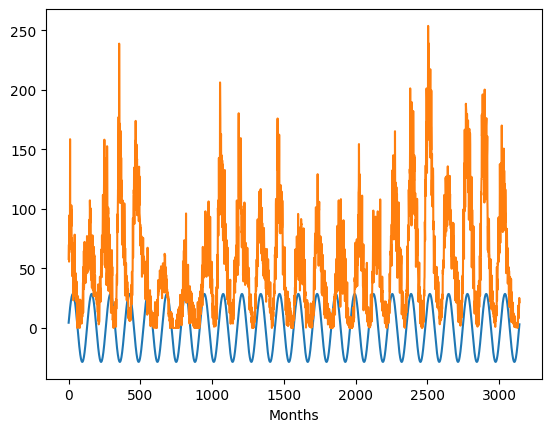

In [6]:
kmax = np.argmax(abs(ck))

filter = np.zeros_like(ck)
filter[kmax] = ck[kmax]
trend = np.fft.irfft(filter)

plt.plot(trend)
plt.plot(spots[:,1])
plt.xlabel('Months')
plt.show()

#### 4) Getting period corresponding to frequency of maximum

If signal is sampled for a total period T and we have N regularly spaced points, the time interval between 
two points is $\Delta = T/N$. The sampling frequency is $f_s = 1/\Delta = N/T$. If there are $N$ coefficients in the 
$c_k$ vector, then the kth coefficients coresponds to a frequency $f = (k/N) f_s$.

In [7]:
# In our case the sampling frequency is one per month 1/month. The frequency corresponding to the max of the spectrum 
# defines the period. fmax = kmax/N 1/month, period = 1/fmax
fmax = kmax/N 
period = 1./fmax
print('Period (yrs) = ', period/12)

Period (yrs) =  10.913194444444443


### How to plot correctly the FT of a Gaussian, using numpy

Plotting below the starting function

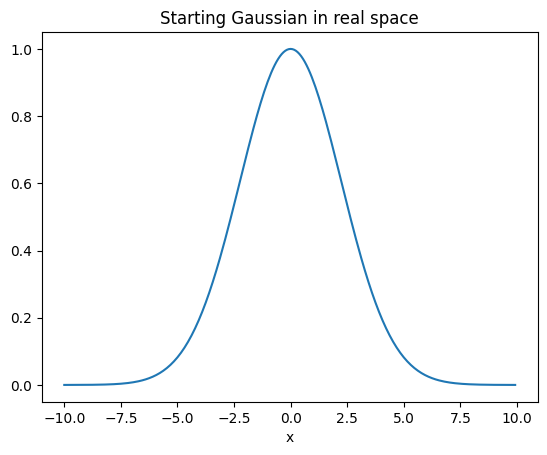

In [141]:
N = 128

x = np.arange(-10,10,10./N)
def func(t): return np.exp(-t**2/10)
y = func(x)
plt.title('Starting Gaussian in real space')
plt.xlabel('x')
plt.plot(x,y)
plt.show()

1. Remember periodic boundary conditions. In real space, if you consider an interval [0,L], you need to arrange the sampled points such that you have the origin on the left, followed by the positive tail, followed by the negative tail. You can do this by hand or using numpy ifftshift, that, does this rearrangement for you.

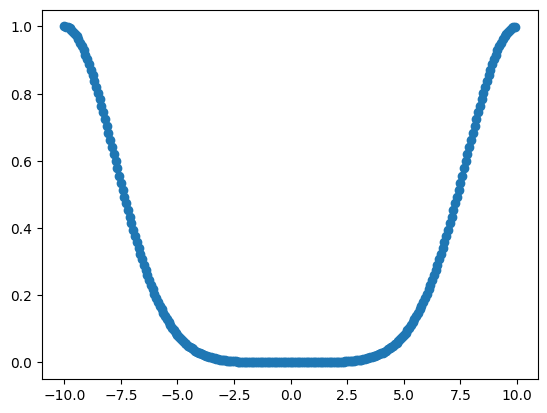

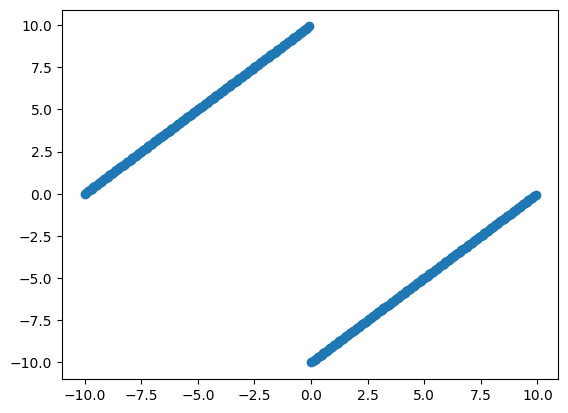

In [142]:
N = 128

x = np.arange(-10,10,10./N)
L = len(x)

def func(t): return np.exp(-t**2/10)
y = func(x)
x = np.fft.ifftshift(np.arange(-10,10,10./N))
plt.scatter(x,y)
plt.show()

#print(x)
plt.scatter(np.arange(-10,10,10./N),x)

2. Fourier transform the Gaussian, using the rearranged x sample. Remember that, in output, python produces and array starting from $0$ frequency, then including in order positive frequencies, followed by negative frequencies, as in the plot below 

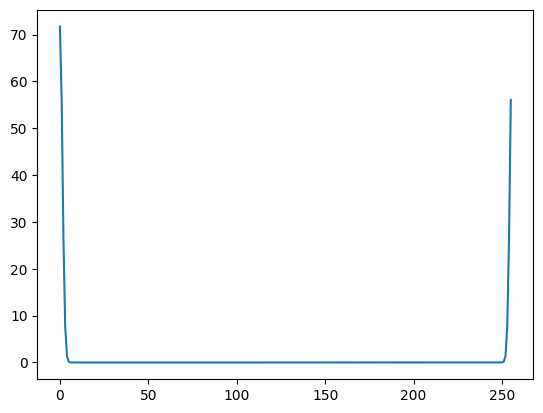

In [143]:
x = np.fft.ifftshift(np.arange(-10,10,10./N))
y = func(x)
y_fft = np.fft.fft(y)

freq = np.fft.fftfreq(len(x))

plt.plot(y_fft)
plt.show()

Therefore, you also want to rearrange the order of the Fourier coefficients, putting negative frequencies first, 0 in the middle, and positive on the right. You can do this with np.fft.fftshift

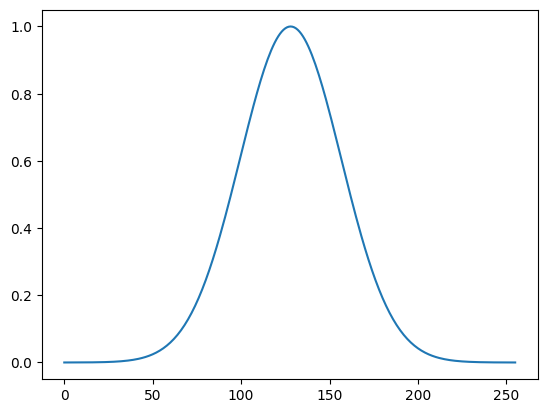

In [144]:
x = np.fft.ifftshift(np.arange(-10,10,10./N))
y = func(x)
y_fft = np.fft.fftshift(y)

plt.plot(y_fft)
plt.show()

Finally, you can plot actual frequencies on the x axis, checking that 0 freq is in the middle. Find frequencies with np.fft.fftfreq and rearrange them with np.fft.ifftshift

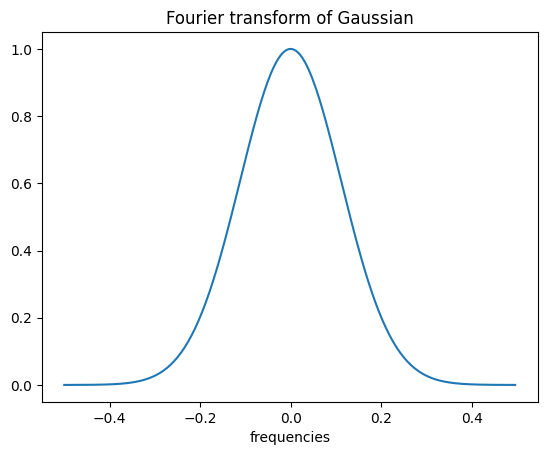

In [145]:
x = np.fft.ifftshift(np.arange(-10,10,10./N))
y = func(x)
y_fft = np.fft.fftshift(y)
f = np.fft.fftfreq(len(x))
f = np.fft.ifftshift(f)

plt.plot(f,y_fft)
plt.title('Fourier transform of Gaussian')
plt.xlabel('frequencies')
plt.show()

You might want to check what happens if you just forget about all of the above, just transform $\exp(-x^2)$ with $x$ in growing order, and plot "naively". The result is displayed below. Not only you have frequncies rearranged, but also oscillations appear. That is because, if you do not rearranging samples in real space, periodic boundary conditions imply that you are shifting the Gaussian mean to the middle of the sampled period (instead of placing it at 0). The translation introduces a phase factor in the Fourier transform.

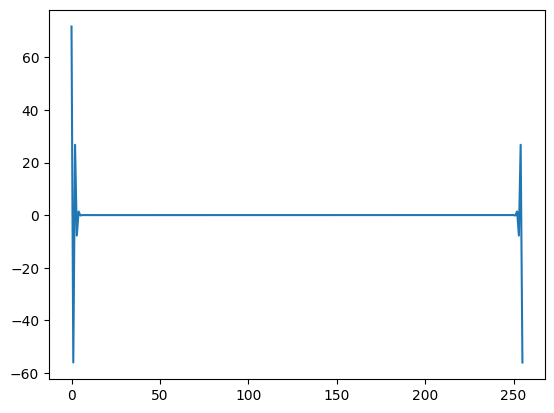

[ 7.17433308e+01+0.j -5.60571826e+01+0.j  2.67389942e+01+0.j
 -7.78736120e+00+0.j  1.38397354e+00+0.j -1.50623407e-01+0.j
  9.64102276e-03+0.j -6.73724529e-04+0.j -2.22753876e-04+0.j
 -2.00510307e-04+0.j -1.73288524e-04+0.j -1.50707188e-04+0.j
 -1.31855018e-04+0.j -1.16066463e-04+0.j -1.02781553e-04+0.j
 -9.15418904e-05+0.j -8.19769736e-05+0.j -7.37889416e-05+0.j
 -6.67385504e-05+0.j -6.06332847e-05+0.j -5.53176867e-05+0.j
 -5.06656548e-05+0.j -4.65743786e-05+0.j -4.29595849e-05+0.j
 -3.97518155e-05+0.j -3.68935083e-05+0.j -3.43367022e-05+0.j
 -3.20412257e-05+0.j -2.99732598e-05+0.j -2.81041941e-05+0.j
 -2.64097102e-05+0.j -2.48690444e-05+0.j -2.34643915e-05+0.j
 -2.21804197e-05+0.j -2.10038752e-05+0.j -1.99232567e-05+0.j
 -1.89285482e-05+0.j -1.80109964e-05+0.j -1.71629266e-05+0.j
 -1.63775885e-05+0.j -1.56490269e-05+0.j -1.49719726e-05+0.j
 -1.43417508e-05+0.j -1.37542029e-05+0.j -1.32056197e-05+0.j
 -1.26926853e-05+0.j -1.22124282e-05+0.j -1.17621793e-05+0.j
 -1.13395365e-05+0.j -1.

In [146]:
N = 128

x = np.arange(-10,10,10./N)
def func(t): return np.exp(-t**2/10)
y = func(x)

y_fft = np.fft.fft(y)
plt.plot(y_fft)
plt.show()

print(y_fft)
